**Import library**

In [ ]:
!pip install pythainlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 11.6 MB/s 


In [ ]:
import tensorflow as tf
Model = tf.keras.models.Model
ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau
load_model = tf.keras.models.load_model

from pythainlp.tokenize import word_tokenize, Tokenizer
KRTokenizer = tf.keras.preprocessing.text.Tokenizer

pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd 

import nltk

# from nltk.corpus import wordnet as wn
# from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('sentiwordnet')
nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('omw-1.4')
# lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

from pythainlp.corpus.common import thai_words
from pythainlp.corpus import thai_stopwords

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Define constant value for model**

In [ ]:
EPOCHS = 1500
BS = 32
DIMENSION = 100

**Read data from each dataset**

In [ ]:
df_kplus = pd.read_csv('/content/KPlus_Googleplay.csv')
df_scb = pd.read_csv('/content/SCB_Easy_Googleplay_cut.csv')
df_ktb = pd.read_csv('/content/Krungthai_next_Googleplay.csv')

**Remove some column from Kplus dataset**

In [ ]:
df_kplus.head(4)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Class
0,9f20248d-8b73-408e-8e06-5556e5e342ad,นายมงคล เขียวบุญแย้ม,https://play-lh.googleusercontent.com/a/ALm5wu...,ชอบแอบนี้มากๆ5.5,5,0,NaN,2022-11-12 06:13:13,ขอขอบคุณ ที่ไว้วางใจใช้บริการ K PLUS ของธนาคาร...,2022-11-12 13:47:24,pos
1,864104fc-01d0-4a44-835d-f1ae41031bfd,Punpun aoorza Goodnow,https://play-lh.googleusercontent.com/a-/ACNPE...,ใช้มาตลอดพออัพเดทล่าสุดนี่เข้าไม่ได้เลยและเด้ง...,2,0,5.16.3,2022-11-12 06:07:28,ขออภัยในความไม่สะดวกที่ได้รับค่ะ เบื้องต้นรบกว...,2022-11-12 13:47:10,neg
2,8f8e9708-35aa-425d-b044-17acfa120fa2,PalmZer Ch,https://play-lh.googleusercontent.com/a-/ACNPE...,ช่วงนี้แอปชอบเปิดเอง ทั้งๆที่ไม่ได้ใช้ ขึ้นมาข...,3,0,5.16.3,2022-11-12 04:54:49,ขออภัยในความไม่สะดวกที่ได้รับนะคะ หากพบปัญหากา...,2022-11-12 16:28:57,neg
3,1225a715-8ad3-4093-90b8-71b3eeaeb7c7,ปรินทร์พร ทิพย์สุวรรณ,https://play-lh.googleusercontent.com/a-/ACNPE...,ช่วงนี้แอฟเด้งมาบ่อยเลยค่ะ ในขณะที่ใช้แอฟอื่นอ...,2,0,5.16.3,2022-11-12 04:39:23,ขออภัยในความไม่สะดวกที่ได้รับนะคะ เบื้องต้นรบก...,2022-11-12 16:28:47,neg


In [ ]:
df_kplus.rename(columns = {'at':'timestamp', 'Class':'class'}, inplace = True)
kplus_remove_columns = ['reviewId', 'userName','userImage','replyContent','repliedAt']
df_kplus.drop(kplus_remove_columns, axis=1, inplace=True)

In [ ]:
df_kplus.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Remove some column from SCB dataset**

In [ ]:
df_scb.head(4)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,Score
0,bb808b6e-7b5f-4708-9cf0-cce451e6b78b,ใหม ใหม่,https://play-lh.googleusercontent.com/a-/ACNPE...,ขยันอัปเดตจัง แต่!!ไม่มีอะไรดีขึ้นเลย,1.0,0.0,3.56.0,2022-11-12 14:47:24,NaN,NaN,neg
1,00475d91-ada3-4416-b84d-6e66c8b18f2b,ความลับในใจ,https://play-lh.googleusercontent.com/a-/ACNPE...,เยี่ยม,5.0,0.0,3.56.0,2022-11-12 13:38:43,NaN,NaN,neg
2,11a3b575-57a5-4922-98b7-1d1e85c27a57,นางสาวชนานุช ดอกประทุม,https://play-lh.googleusercontent.com/a/ALm5wu...,ไม่สามารถโหลดเพื่ออัพเดทแอปได้เมมเต็ม,5.0,0.0,3.56.0,2022-11-12 13:06:09,NaN,NaN,neg
3,cf0553f1-6bcf-499f-82e3-13757311f66e,SuKuRuLo KoHeJiNaTo,https://play-lh.googleusercontent.com/a/ALm5wu...,แอปเป็นอะไรวะทำไทถึงเข้าไม่ได้อ่า แก้ไขหน่อยนะ,1.0,0.0,3.56.0,2022-11-12 13:05:33,NaN,NaN,neg


In [ ]:
df_scb.rename(columns = {'at':'timestamp', 'Score':'class'}, inplace = True)
scb_remove_columns = ['reviewId', 'userName','userImage','replyContent','repliedAt']
df_scb.drop(kplus_remove_columns, axis=1, inplace=True)

In [ ]:
df_scb.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Remove some column from KTB dataset**

In [ ]:
df_ktb.head(4)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,Time Stamp,Label,Unnamed: 9
0,bdfd375a-701e-4bc4-a5ff-ac1405a4f063,สุริยา ณ.สมุทร,https://play-lh.googleusercontent.com/a-/ACNPE...,ดี,5,0,11.9.1,2022-11-12 07:17:54,pos,NaN
1,9181b9cf-bc01-4b90-bc65-aa67ae5ebb81,Jumlean Luecha,https://play-lh.googleusercontent.com/a/ALm5wu...,Good,5,0,11.9.1,2022-11-12 06:53:18,pos,NaN
2,f14a5783-0f0f-4c1c-b9d4-7ea0d78f52cf,SAMLEE TRUDMAKKA,https://play-lh.googleusercontent.com/a/ALm5wu...,ให้บริการดีขอบคุณมากค่ะ,5,0,11.9.1,2022-11-12 06:50:52,pos,NaN
3,3ad1db88-f0c1-4e0f-8853-92352f070acc,มาหามะรอมือลี เห็ง,https://play-lh.googleusercontent.com/a/ALm5wu...,รุ่.,4,0,11.6.3,2022-11-12 06:27:40,?,NaN


In [ ]:
df_ktb.rename(columns = {'Time Stamp':'timestamp', 'Label':'class'}, inplace = True)
ktb_remove_columns = ['reviewId', 'userName','userImage','Unnamed: 9']
df_ktb.drop(ktb_remove_columns, axis=1, inplace=True)

In [ ]:
df_ktb.columns

Index(['content', 'score', 'thumbsUpCount', 'reviewCreatedVersion',
       'timestamp', 'class'],
      dtype='object')

**Merged dataset into dataframe**

In [ ]:
df = pd.concat([df_kplus, df_scb, df_ktb], ignore_index=True, sort=False)

In [ ]:
df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
0,ชอบแอบนี้มากๆ5.5,5.0,0.0,NaN,2022-11-12 06:13:13,pos
1,ใช้มาตลอดพออัพเดทล่าสุดนี่เข้าไม่ได้เลยและเด้ง...,2.0,0.0,5.16.3,2022-11-12 06:07:28,neg
2,ช่วงนี้แอปชอบเปิดเอง ทั้งๆที่ไม่ได้ใช้ ขึ้นมาข...,3.0,0.0,5.16.3,2022-11-12 04:54:49,neg
3,ช่วงนี้แอฟเด้งมาบ่อยเลยค่ะ ในขณะที่ใช้แอฟอื่นอ...,2.0,0.0,5.16.3,2022-11-12 04:39:23,neg
4,ดี,5.0,0.0,5.16.3,2022-11-12 04:34:57,pos


**Check data type**

In [ ]:
df.dtypes

content                  object
score                   float64
thumbsUpCount           float64
reviewCreatedVersion     object
timestamp                object
class                    object
dtype: object

**Check null value and clean column**

In [ ]:
df.isnull().sum()

content                   1
score                     1
thumbsUpCount             1
reviewCreatedVersion    751
timestamp                 1
class                     8
dtype: int64

In [ ]:
df['content'] = df['content'].astype('str') 
df['content'] = df['content'].replace(np.nan,"")

In [ ]:
df['score'] = df['score'].replace(np.nan,0)

In [ ]:
df['thumbsUpCount'] = df['thumbsUpCount'].replace(np.nan,0)

In [ ]:
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].astype('str') 
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].replace("nan","0.0.0")
df['reviewCreatedVersion'] = df['reviewCreatedVersion'].replace("","0.0.0")

In [ ]:
df['timestamp'] = df['timestamp'].astype('str') 
df['timestamp'] = df['timestamp'].replace(np.nan,"")

In [ ]:
df['class'].value_counts()

pos    1800
neg    1522
?       214
xxx       6
Name: class, dtype: int64

In [ ]:
df['class'] = df['class'].astype('str') 
df['class'] = df['class'].replace("nan","?")
df['class'] = df['class'].replace("xxx","?")

In [ ]:
df['class'].value_counts()

pos    1800
neg    1522
?       228
Name: class, dtype: int64

In [ ]:
df.isnull().sum()

content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
timestamp               0
class                   0
dtype: int64

**From above class value count**

* We should sample class with equal row number. (pos=1522, neg=1522)
* For alternative class("?"), predict in next model

In [ ]:
pos_df = df[df['class'] == "pos"].sample(1522, random_state = 42)
pos_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
3110,ถูกใจ,5.0,0.0,11.9.1,2022-10-25 07:29:15,pos
1756,ใช้ด้ดีมากๆ,5.0,0.0,3.60.0,2022-10-31 06:56:03,pos
1641,สดวกใช้ง่าย,5.0,0.0,3.60.0,2022-11-04 19:25:52,pos
293,ดี,5.0,0.0,5.16.1,2022-11-06 18:19:54,pos
2335,ฉันชอบมากทุกวัน❤️❤️❤️,5.0,1.0,3.59.0,2022-10-07 05:03:46,pos
...,...,...,...,...,...,...
3516,ขอบคุณครับ,5.0,0.0,11.9.1,2022-10-11 10:17:21,pos
3339,ใช้แล้วดี,3.0,0.0,11.8.1,2022-10-18 12:54:47,pos
1017,ยอดเยี่ยมชอบมาก,5.0,0.0,5.16.1,2022-10-22 10:45:54,pos
1731,ดีมาก,5.0,0.0,3.60.0,2022-10-31 22:57:43,pos


In [ ]:
neg_df = df[df['class'] == "neg"].sample(1522, random_state = 42)
neg_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg
...,...,...,...,...,...,...
2595,ห่วยแตกโอนเงินไม่เข้า,1.0,0.0,0.0.0,2022-11-11 00:28:13,neg
3043,สิ้นเดือนมีปัญหาตลอด ทำไมไม่เคยหาทางแก้ไขเนี่ย...,1.0,0.0,11.9.1,2022-10-25 08:52:53,neg
2143,และ app เป็นไรชอบล่มตอน 23:00 น กับเที่ยงคืนแล...,1.0,0.0,0.0.0,2022-10-12 18:49:26,neg
3329,แย่ชิปหาย ปรุงเถอะ เวลาเปลี่ยนเครื่องยังต้องแส...,1.0,6.0,11.9.1,2022-10-19 01:49:12,neg


In [ ]:
unknown_df = df[df['class'] == "?"]
unknown_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
84,CC6844421,5.0,0.0,5.16.3,2022-11-10 18:04:18,?
94,ิอิอิ,5.0,0.0,5.16.3,2022-11-10 14:18:38,?
144,i ij!!,3.0,0.0,5.16.1,2022-11-09 19:25:31,?
147,ดี,4.0,0.0,0.0.0,2022-11-09 15:16:32,?
164,~ช,5.0,0.0,5.16.1,2022-11-09 10:29:10,?
...,...,...,...,...,...,...
3524,กู้เงินสินเชื่อ,4.0,0.0,0.0.0,2022-10-11 05:17:39,?
3526,ลองใช้ก่อน,1.0,0.0,0.0.0,2022-10-11 04:44:04,?
3527,11/10/22 09:00-09:46เข้าแอพไม่ได้ครับ,3.0,0.0,11.5.5,2022-10-11 02:46:25,?
3541,ตคคตจ,4.0,0.0,11.9.1,2022-10-10 09:51:25,?


**Text PreProcessing**
*   Removing Punctuations
*   Change Case
*   Tokenization
*   Removing Stop Words
*   Lemmatization

In [ ]:
sentiment_df = pd.concat([neg_df, pos_df])
sentiment_df

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg
...,...,...,...,...,...,...
3516,ขอบคุณครับ,5.0,0.0,11.9.1,2022-10-11 10:17:21,pos
3339,ใช้แล้วดี,3.0,0.0,11.8.1,2022-10-18 12:54:47,pos
1017,ยอดเยี่ยมชอบมาก,5.0,0.0,5.16.1,2022-10-22 10:45:54,pos
1731,ดีมาก,5.0,0.0,3.60.0,2022-10-31 22:57:43,pos


In [ ]:
sentiment_df['clean_comments'] = sentiment_df['content'].fillna('').apply(lambda x: x.lower())
sentiment_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg,พอจะรีบใช้งาน มีปัญหาทุกครั้ง
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒


In [ ]:
pun = '"#\'()*,-.;<=>[\\]^_`{|}~'
pun

'"#\'()*,-.;<=>[\\]^_`{|}~'

In [ ]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].str.replace(r'[%s]' % (pun), '', regex=True)
sentiment_df.sample(5)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
2166,ดีครับ,5.0,0.0,0.0.0,2022-10-11 20:23:59,pos,ดีครับ
1211,ปรับปรุงด้วยนะคะพออัปเดตแล้วมันก็เด้งออกบ่อยมา...,1.0,0.0,0.0.0,2022-10-18 12:03:24,neg,ปรับปรุงด้วยนะคะพออัปเดตแล้วมันก็เด้งออกบ่อยมา...
2746,แย่,1.0,0.0,0.0.0,2022-11-04 07:31:43,neg,แย่
2179,ไม่มีอะไรบอก,5.0,0.0,3.59.0,2022-10-11 11:21:00,neg,ไม่มีอะไรบอก
2498,ทำไมสรุปยอดใช่จ่ายไม่ขึ้นครับ ไม่เอาแบบต้องแบบ...,1.0,0.0,3.59.0,2022-10-01 17:39:41,neg,ทำไมสรุปยอดใช่จ่ายไม่ขึ้นครับ ไม่เอาแบบต้องแบบ...


Custom word

In [ ]:
THAI_CUSTOM_WORDS = '/content/thai_custom_words2.txt'
THAI_STOP_WORDS = '/content/thai_stop_words.txt'
THAI_CORRECT_WORDS = '/content/thai_correct_words.txt'

In [ ]:
custom_words_list = set(thai_words())
len(custom_words_list)

62055

In [ ]:
custom_words_list

{'เกลือด่าง',
 'อังกาบฝรั่ง',
 'ศราวณะ',
 'เทียมบ่าเทียมไหล่',
 'กระบวนความ',
 'ปริ่ม',
 'หยั่งกับ',
 'เห็นใจ',
 'คำโบล',
 'แกะรอย',
 'มอมหน้ามอมตา',
 'กระเบื้องซีเมนต์ใยหิน',
 'เอนเซฟาลิติส',
 'กระเดือก',
 'โกปินำ',
 'ซอล',
 'โฆรวิส',
 'จริงอยู่',
 'การค้นคว้า',
 'ไวทัล',
 'ความประหม่า',
 'กั้นบัง',
 'คุรุกรรม',
 'ค็อกคัส',
 'วฤษละ',
 'ลายฉลุ',
 'ไม่เข้าใครออกใคร',
 'กระดังงาลนไฟ',
 'ปาส',
 'ดวงสมร',
 'แอนตี้',
 'ทางตัน',
 'ยาขัด',
 'กรรกง',
 'เหตุสุดวิสัย',
 'ธนกิจ',
 'ตะบุ้ย ๆ',
 'เพลีย',
 'เปล่า',
 'โรงไฟฟ้า',
 'เมื่อยขบ',
 'รถประเทียบ',
 'งาเนียม',
 'ถ่ายทำ',
 'กระเหี้ยนกระหือรือ',
 'เข้าวัดเข้าวา',
 'ตีรั้ง',
 'ราชพิธี',
 'หลักแหล่ง',
 'การเล่นคำ',
 'สำเพ็ง',
 'คาดการณ์ล่วงหน้า',
 'โถวหยุย',
 'สมาส',
 'หอยงวงช้างมุก',
 'ตุ่นต่าน',
 'เดฟ',
 'ป.ล.',
 'รอยต่อ',
 'ทวนทบ',
 'กวีนิพนธ์',
 'รับสารภาพ',
 'โรงเลี้ยงเด็ก',
 'ข้อหาฉกรรจ์',
 'ย่ำค่ำ',
 'บอส',
 'ผ้าขาวม้า',
 'นิ้ม',
 'สัญญาณรบกวน',
 'การปั้นรูป',
 'ความหมาย',
 'คำคม',
 'มาลัยชายเดียว',
 'เรือนฝากระดาน',
 'ข่มขืนกระทำชำเรา',
 

In [ ]:
with open(THAI_CUSTOM_WORDS, encoding='utf8') as f:
    words = [line.strip() for line in f]

words

['เคแบง',
 'เคแบงก์',
 'Kplus',
 'กรุงไทย',
 'เคพลัส',
 'เคพัส',
 'K PLUS',
 'KPLUS',
 'k plus',
 'SCB',
 'ไทยพานิต',
 'คิวอาร์โค้ด',
 'กสิกรไทย',
 'คิวอาร์',
 'รีบูต',
 'ดีเลย์',
 'แอปพลิเคชัน',
 'แอป',
 'แอบ',
 'แอ๊ป',
 'แอฟ',
 'แอ้ป',
 'แอบ',
 'แอพ',
 'แอพปริชั่น',
 'เธ๊ออออ',
 'สดวก',
 'ก้อ',
 'ใด้',
 'จังกวะ',
 'หร้า',
 'เปยี่ยน',
 'เป้น',
 'บันชี',
 'บัชชี',
 'โคต',
 'โครต',
 'ไห้',
 'อารมย์',
 'สะดววก',
 'ธนาคาน',
 'รำคาน',
 'สามรถ',
 'คัฟ',
 'อัพเดต',
 'อัพเดท',
 'อัพเดท',
 'อัปเดท',
 'อัทเดท',
 'ครัย',
 'เรย',
 'งา่ย',
 'จัย',
 'ระหัส',
 'มรึง',
 'ธนาคาา',
 'ธนคาร',
 'บรืการ']

In [ ]:
custom_words_list.update(words)
len(custom_words_list)

62099

Tokenization

In [ ]:
custom_tokenizer = Tokenizer(custom_words_list)

In [ ]:
sentiment_df['clean_comments'] = sentiment_df['clean_comments'].apply(lambda x: custom_tokenizer.word_tokenize(x))

In [ ]:
sentiment_df.sample(5)

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
982,จู่ๆเข้าแอพมาแอพก็ล็อกค่ะ ทั้งๆที่ยังไม่ได้ใส่...,5.0,0.0,5.16.1,2022-10-23 10:32:04,neg,"[จู่ๆ, เข้า, แอพ, มา, แอพ, ก็, ล็อก, ค่ะ, , ท..."
1501,เยี่ยม,5.0,0.0,3.56.0,2022-11-12 13:38:43,neg,[เยี่ยม]
2381,ตอนนี้ก็ใช้งานไม่ได้ 5-10-65/11.30น. ถ้าชดเชยค...,1.0,0.0,3.59.0,2022-10-05 04:44:33,neg,"[ตอนนี้, ก็, ใช้งาน, ไม่, ได้, , 51065, /, 11..."
2274,ให้ห้าดาวครับพัฒนาต่อไปอย่าหยุดยั้ง,5.0,0.0,3.53.0,2022-10-08 06:55:46,pos,"[ให้, ห้า, ดาว, ครับ, พัฒนา, ต่อไป, อย่า, หยุด..."
2118,ดีมากๆๆ,5.0,0.0,3.58.0,2022-10-13 23:15:11,pos,"[ดีมาก, ๆๆ]"


In [ ]:
tokenized_doc = sentiment_df['clean_comments']
tokenized_doc[:10]

1347          [พอ, จะ, รีบ, ใช้งาน,  , มีปัญหา, ทุกครั้ง]
2536    [อัปเดต, แทนที่, แอพพลิเคชัน, จะ, ดีกว่า, เดิม...
3366    [ทำ, มัย, เบอร์, ต้อง, ตรงเวลา, สำคัญ, ทำ, ไม่...
2770    [มีปัญหา, อยู่, อย่างหนึ่ง, และ, ก้เปน, อยู่, ...
2411           [อยู่ดีๆ, แอป, ก้อ, ล็อค, เอง, เฉย,  , 😒😒]
1054    [ใช้, ยุ่งยาก, ชิบหาย,  , บาง, คนใช้, รายเดือน...
2134    [ทำไม, ต้อง, ติดต่อ, ธนาคาร, ครับ, เข้าไป, แล้...
3440                                [ระบบ, ช้า, มาก, ค่ะ]
2447    [แอป, มี, ปัญญา, หา, อะไร, หนักหนา, ครับ, ล่ม,...
2514    [จำได้, ว่า, เคย, ให้คะแนน, แอป, ดีมาก,  , แต่...
Name: clean_comments, dtype: object

Delete english stop word

In [ ]:
 tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
 tokenized_doc[:10]

Delete thai stop word

In [ ]:
 th_stop_words = list(thai_stopwords())
 tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in th_stop_words])

In [ ]:
 tokenized_doc[:10]

Correct Word

In [ ]:
with open(THAI_CORRECT_WORDS) as f:
    thai_correct_word_list = [line.strip() for line in f]
    
thai_correct_word_list

['แอป แอปพลิเคชัน',
 'แอบ แอปพลิเคชัน',
 'แอ๊ป แอปพลิเคชัน',
 'แอฟ แอปพลิเคชัน',
 'แอ้ป แอปพลิเคชัน',
 'แอบ แอปพลิเคชัน',
 'แอพ แอปพลิเคชัน',
 'แอพปริชั่น แอปพลิเคชัน',
 'เธ๊ออออ เธอ',
 'สดวก สะดวก',
 'ก้อ ก็',
 'ใด้ ได้',
 'จังกวะ จังหวะ',
 'หร้า หน้า',
 'เปยี่ยน เปลี่ยน',
 'เป้น เป็น',
 'บันชี บัญชี',
 'บัชชี บัญชี',
 'โคต โคตร',
 'โครต โคตร',
 'ไห้ ให้',
 'อารมย์ อารมณ์',
 'สะดววก สะดวก',
 'ธนาคาน ธนาคาร',
 'รำคาน รำคาญ',
 'สามรถ สามารถ',
 'คัฟ ครับ',
 'อัพเดต อัปเดต',
 'อัพเดท อัปเดต',
 'อัพเดท อัปเดต',
 'อัปเดท อัปเดต',
 'อัทเดท อัปเดต',
 'ครัย ครับ',
 'เรย เลย',
 'งา่ย ง่าย',
 'จัย ใจ',
 'ระหัส รหัส',
 'มรึง มึง',
 'ธนาคาา ธนาคาร',
 'ธนคาร ธนาคาร',
 'บรืการ บริการ']

In [ ]:
correct_pair={}

for pair in thai_correct_word_list:
    correct_pair[pair.split()[0].strip()]=pair.split()[1].strip() 

In [ ]:
doc = []
for tokenized_list in tokenized_doc:
    for index, word in enumerate(tokenized_list):
        if word in correct_pair:
            tokenized_list[index]=correct_pair[word]
    doc.append(tokenized_list)
    
tokenized_doc = pd.Series(doc)

In [ ]:
tokenized_doc

0             [พอ, จะ, รีบ, ใช้งาน,  , มีปัญหา, ทุกครั้ง]
1       [อัปเดต, แทนที่, แอพพลิเคชัน, จะ, ดีกว่า, เดิม...
2       [ทำ, มัย, เบอร์, ต้อง, ตรงเวลา, สำคัญ, ทำ, ไม่...
3       [มีปัญหา, อยู่, อย่างหนึ่ง, และ, ก้เปน, อยู่, ...
4       [อยู่ดีๆ, แอปพลิเคชัน, ก็, ล็อค, เอง, เฉย,  , 😒😒]
                              ...                        
3039                                       [ขอบคุณ, ครับ]
3040                                        [ใช้แล้ว, ดี]
3041                                [ยอดเยี่ยม, ชอบ, มาก]
3042                                              [ดีมาก]
3043                                                 [ดี]
Length: 3044, dtype: object

De-tokenization

In [ ]:
tokenized_doc = tokenized_doc.to_list()

In [ ]:
# de-tokenization
detokenized_doc = []
for i in range(len(tokenized_doc)):
#     print(tokenized_doc[i])
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
    
sentiment_df['clean_comments'] = detokenized_doc

In [ ]:
sentiment_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
1347,พอจะรีบใช้งาน มีปัญหาทุกครั้ง,1.0,0.0,5.16.1,2022-10-16 10:02:21,neg,พอ จะ รีบ ใช้งาน มีปัญหา ทุกครั้ง
2536,อัปเดตแทนที่แอพพลิเคชันจะดีกว่าเดิมแต่ยิ่งอัปเ...,1.0,7.0,3.59.0,2022-09-30 07:32:45,neg,อัปเดต แทนที่ แอพพลิเคชัน จะ ดีกว่า เดิม แต่ ย...
3366,ทำมัยเบอร์ต้องตรงเวลาสำคัญทำไม่ได้เลยแย่มากๆ,1.0,0.0,11.9.1,2022-10-17 14:05:44,neg,ทำ มัย เบอร์ ต้อง ตรงเวลา สำคัญ ทำ ไม่ ได้ เลย...
2770,มีปัญหาอยู่อย่างหนึ่งและก้เปนอยู่บ่อยๆ..เวลาโอ...,3.0,6.0,11.9.1,2022-11-03 03:47:13,neg,มีปัญหา อยู่ อย่างหนึ่ง และ ก้เปน อยู่ บ่อยๆ เ...
2411,อยู่ดีๆแอปก้อล็อคเองเฉย 😒😒,2.0,0.0,0.0.0,2022-10-04 11:40:20,neg,อยู่ดีๆ แอปพลิเคชัน ก็ ล็อค เอง เฉย 😒😒


In [ ]:
Split test data

In [ ]:
temp_df = sentiment_df

sentiment_df = temp_df.sample(2435, random_state = 42)
test_df = temp_df.sample(609, random_state = 42) #total 3044 rows, train 609 rows, test 2435 rows

In [ ]:
cleaned_words = sentiment_df['clean_comments'].to_list()

In [ ]:
cleaned_words[:1]

['สแกน ใบหน้า ไม่ ดี ระบบ ควร ปรับปรุง']

**Tokenization with keras (use vector result from keras)**

In [ ]:
def create_tokenizer(words, filters = ''):
    token = KRTokenizer()
    token.fit_on_texts(words)
    return token

In [ ]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'ไม่': 1,
 'ได้': 2,
 'แอปพลิเคชัน': 3,
 'ดี': 4,
 'ครับ': 5,
 'เข้า': 6,
 'เลย': 7,
 'ก็': 8,
 'มาก': 9,
 'จะ': 10,
 'ใช้': 11,
 'ดีมาก': 12,
 'แล้ว': 13,
 'ค่ะ': 14,
 'ให้': 15,
 'เงิน': 16,
 'ๆ': 17,
 'อะไร': 18,
 'มา': 19,
 'มี': 20,
 'ไป': 21,
 'บ่อย': 22,
 'แต่': 23,
 'โอน': 24,
 'ที่': 25,
 'ทำ': 26,
 '\u200b': 27,
 'ธนาคาร': 28,
 'เป็น': 29,
 'ใช้งาน': 30,
 'ต้อง': 31,
 'อัปเดต': 32,
 'ทำไม': 33,
 'เด้ง': 34,
 'สะดวก': 35,
 'ระบบ': 36,
 'ใหม่': 37,
 'นี้': 38,
 'เปิด': 39,
 'คับ': 40,
 'ยัง': 41,
 'นะ': 42,
 'มัน': 43,
 'ชอบ': 44,
 'แย่มาก': 45,
 'คะ': 46,
 'ขึ้น': 47,
 'ว่า': 48,
 'ด้วย': 49,
 'ล่ม': 50,
 'ตลอด': 51,
 'ปรับปรุง': 52,
 'แก้ไข': 53,
 'บริการ': 54,
 'มีปัญหา': 55,
 'ใน': 56,
 'แย่': 57,
 'กด': 58,
 'ห่วย': 59,
 'ง่าย': 60,
 'ออก': 61,
 'พอ': 62,
 'ช้า': 63,
 'ยาก': 64,
 'อยู่': 65,
 'และ': 66,
 'การ': 67,
 'โหลด': 68,
 'ผม': 69,
 'สมัคร': 70,
 'บัญชี': 71,
 'ปิด': 72,
 'หน่อย': 73,
 'เวลา': 74,
 'บอก': 75,
 'เครื่อง': 76,
 'จ่าย': 77,
 'สแกน': 78,
 'เอง': 79,
 '

In [ ]:
tokenized_doc[:3]

[['พอ', 'จะ', 'รีบ', 'ใช้งาน', ' ', 'มีปัญหา', 'ทุกครั้ง'],
 ['อัปเดต',
  'แทนที่',
  'แอพพลิเคชัน',
  'จะ',
  'ดีกว่า',
  'เดิม',
  'แต่',
  'ยิ่ง',
  'อัปเดต',
  'ยิ่ง',
  'แย่',
  'และ',
  'เป็น',
  'ธนาคาร',
  'ที่',
  'อัปเดต',
  'แอปพลิเคชัน',
  'บ่อย',
  'ที่สุด',
  'แย่มาก',
  'ครับ',
  ' ',
  'มีธุระ',
  'ที่',
  'ต้อง',
  'ใช้',
  'เงิน',
  'แต่',
  'แอพพลิเคชัน',
  'เข้า',
  'ใช้งาน',
  'ไม่',
  'ได้',
  'เป็น',
  'บ่อย',
  'มาก',
  ' ',
  'พัฒนา',
  'อัปเดต',
  'แทนที่จะ',
  'ดีแต่',
  'แย่',
  'กว่า',
  'เก่า',
  'มาก',
  ' ',
  'ระบบ',
  'มีปัญหา',
  'บ่อย',
  'มาก',
  'ไทย',
  'พา',
  'นิ',
  'ชย',
  '์',
  'ธนาคาร',
  'อื่น',
  'ดีกว่า',
  'เมื่อ',
  'เปรียบเทียบ',
  'แอพพลิเคชัน'],
 ['ทำ',
  'มัย',
  'เบอร์',
  'ต้อง',
  'ตรงเวลา',
  'สำคัญ',
  'ทำ',
  'ไม่',
  'ได้',
  'เลย',
  'แย่มาก',
  'ๆ']]

In [ ]:
def max_length(words):
    return(len(max(words, key = len)))

In [ ]:
max_length = max_length(tokenized_doc)
max_length

174

In [ ]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

In [ ]:
print(cleaned_words[0])
print(encoded_doc[0])

สแกน ใบหน้า ไม่ ดี ระบบ ควร ปรับปรุง
[78, 153, 1, 4, 36, 211, 52]


In [ ]:
def padding_doc(encoded_doc, max_length):
   return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (2435, 174)
สแกน ใบหน้า ไม่ ดี ระบบ ควร ปรับปรุง
[78, 153, 1, 4, 36, 211, 52]
[ 78 153   1   4  36 211  52   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
category = sentiment_df['class'].to_list()

In [ ]:
unique_category = list(set(category))
unique_category

['neg', 'pos']

In [ ]:
output_tokenizer = create_tokenizer(unique_category)

In [ ]:
encoded_output = encoding_doc(output_tokenizer, category)
print(category[1:2])
print(encoded_output[1:2])

['pos']
[[2]]


In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(2435, 1)

In [ ]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False)
  return(oh.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[1]
[1. 0.]


**Train and validation split**

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

In [ ]:
# train_X, test_X, train_Y, test_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

# train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.25) # 0.25 x 0.8 = 0.2

In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (1948, 174) and train_Y = (1948, 2)
Shape of val_X = (487, 174) and val_Y = (487, 2)


In [ ]:
num_classes = len(unique_category)

In [ ]:
num_classes

2

**Initial learning rate**

In [ ]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)

**Define CNN model**

In [ ]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = tf.keras.layers.Input(shape=(length,))
    embedding1 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs1)
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
    flat1 = tf.keras.layers.Flatten()(pool1)
    # channel 2
    inputs2 = tf.keras.layers.Input(shape=(length,))
    embedding2 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs2)
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
    flat2 = tf.keras.layers.Flatten()(pool2)
    # channel 3
    inputs3 = tf.keras.layers.Input(shape=(length,))
    embedding3 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = True)(inputs3)
    conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = tf.keras.layers.Dropout(0.5)(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
    flat3 = tf.keras.layers.Flatten()(pool3)
    # merge
    merged = tf.keras.layers.concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = tf.keras.layers.Dense(10, activation='relu')(merged)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
vocab_size

2499

In [ ]:
model = define_model(max_length, vocab_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 174, 100)     249900      ['input_1[0][0]']                
                                                                                              

In [ ]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
hist = model.fit([train_X, train_X, train_X], train_Y, epochs = EPOCHS, batch_size = BS, validation_data = ([val_X, val_X, val_X], val_Y), callbacks = [callbacks_list], shuffle=True)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.7110
Epoch 1: val_loss improved from inf to 0.62046, saving model to model.h5
61/61 [==============================] - 7s 88ms/step - loss: 0.6521 - accuracy: 0.7110 - val_loss: 0.6205 - val_accuracy: 0.7269 - lr: 1.0000e-04
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.5415 - accuracy: 0.7823
Epoch 2: val_loss improved from 0.62046 to 0.52101, saving model to model.h5
61/61 [==============================] - 5s 83ms/step - loss: 0.5415 - accuracy: 0.7823 - val_loss: 0.5210 - val_accuracy: 0.7885 - lr: 1.0000e-04
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.4420 - accuracy: 0.8121
Epoch 3: val_loss improved from 0.52101 to 0.45930, saving model to model.h5
61/61 [==============================] - 5s 82ms/step - loss: 0.4420 - accuracy: 0.8121 - val_loss: 0.4593 - val_accuracy: 0.8090 - lr: 1.0000e-04
Epoch 4/100
61/61 [============================

In [ ]:
h1 = go.Scatter(y=hist.history['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=hist.history['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
h1 = go.Scatter(y=hist.history['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=hist.history['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
predict_model = load_model(filename) 
predict_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 174, 100)     249900      ['input_1[0][0]']                
                                                                                              

In [ ]:
score = predict_model.evaluate([val_X, val_X, val_X], val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.15869030356407166
Validate accuracy: 0.9425051212310791


In [ ]:
predicted_classes = np.argmax(predict_model.predict([val_X, val_X, val_X]), axis=-1)
predicted_classes.shape

16/16 [==============================] - 0s 16ms/step


(487,)

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[1. 0.]
0


In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

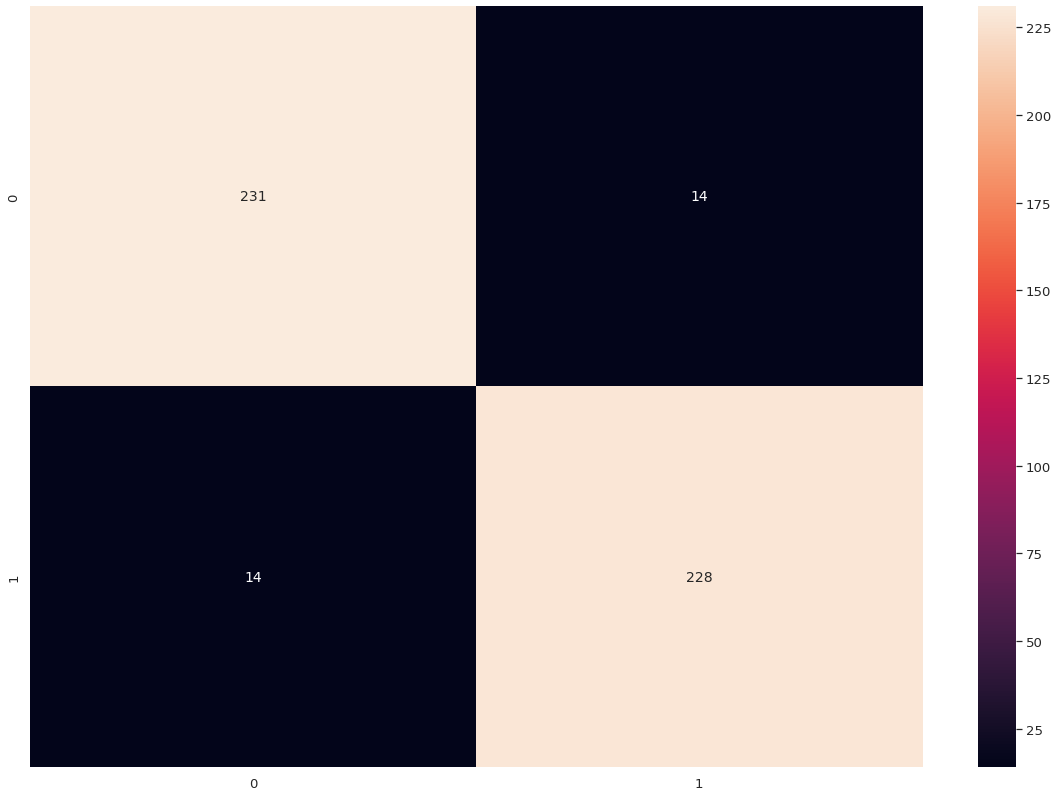

In [ ]:
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
label_dict = output_tokenizer.word_index

In [ ]:
label = [key for key, value in label_dict.items()]

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         neg     0.9429    0.9429    0.9429       245
         pos     0.9421    0.9421    0.9421       242

    accuracy                         0.9425       487
   macro avg     0.9425    0.9425    0.9425       487
weighted avg     0.9425    0.9425    0.9425       487



# CNN with word Embedding Gensim

In [ ]:
sentences = [st.split() for st in cleaned_words]

In [ ]:
w2v_model = Word2Vec(sentences, min_count=1, size=DIMENSION, workers=6, sg=1, iter=500)

In [ ]:
w2v_model.save('w2v_model.bin')

In [ ]:
new_model = Word2Vec.load('w2v_model.bin')

In [ ]:
embedding_matrix = np.zeros((vocab_size, DIMENSION))

for word, i in train_word_tokenizer.word_index.items():
    if word in new_model.wv.vocab:
        embedding_vector = new_model.wv[word]
        embedding_matrix[i] = embedding_vector

In [ ]:
# define the model
def define_w2v_model(length, vocab_size, embedding_matrix):
    # channel 1
    inputs1 = tf.keras.layers.Input(shape=(length,))
    embedding1 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = False, weights=[embedding_matrix])(inputs1)
    conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = tf.keras.layers.Dropout(0.5)(conv1)
    pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
    flat1 = tf.keras.layers.Flatten()(pool1)
    # channel 2
    inputs2 = tf.keras.layers.Input(shape=(length,))
    embedding2 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = False, weights=[embedding_matrix])(inputs2)
    conv2 = tf.keras.layers.Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = tf.keras.layers.Dropout(0.5)(conv2)
    pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
    flat2 = tf.keras.layers.Flatten()(pool2)
    # channel 3
    inputs3 = tf.keras.layers.Input(shape=(length,))
    embedding3 = tf.keras.layers.Embedding(vocab_size, DIMENSION, trainable = False, weights=[embedding_matrix])(inputs3)
    conv3 = tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = tf.keras.layers.Dropout(0.5)(conv3)
    pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
    flat3 = tf.keras.layers.Flatten()(pool3)
    # merge
    merged = tf.keras.layers.concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = tf.keras.layers.Dense(10, activation='relu')(merged)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [ ]:
model2 = define_w2v_model(max_length, vocab_size, embedding_matrix)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 174, 100)     249900      ['input_4[0][0]']                
                                                                                            

In [ ]:
filename = 'model2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [ ]:
EPOCHS_2 = 1500 

In [ ]:
hist2 = model2.fit([train_X, train_X, train_X], train_Y, epochs = EPOCHS_2, batch_size = BS, validation_data = ([val_X, val_X, val_X], val_Y), callbacks = [callbacks_list], shuffle=True)


เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
Epoch 251/1500
61/61 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8978
Epoch 251: val_loss improved from 0.41505 to 0.41423, saving model to model2.h5
61/61 [==============================] - 4s 70ms/step - loss: 0.3430 - accuracy: 0.8978 - val_loss: 0.4142 - val_accuracy: 0.8624 - lr: 1.0000e-06
Epoch 252/1500
61/61 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.8937
Epoch 252: val_loss improved from 0.41423 to 0.41343, saving model to model2.h5
61/61 [==============================] - 4s 68ms/step - loss: 0.3463 - accuracy: 0.8937 - val_loss: 0.4134 - val_accuracy: 0.8624 - lr: 1.0000e-06
Epoch 253/1500
61/61 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8953
Epoch 253: val_loss improved from 0.41343 to 0.41263, saving model to model2.h5
61/61 [==============================] - 4s 70ms/step - loss: 0.3432 - accuracy: 0.8953 - val_loss: 0.4126 - val_ac

In [ ]:
h1 = go.Scatter(y=hist2.history['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=hist2.history['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
h1 = go.Scatter(y=hist2.history['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=hist2.history['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
predict_model2 = load_model(filename) 
predict_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 174)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 174, 100)     249900      ['input_4[0][0]']                
                                                                                            

In [ ]:
score = predict_model2.evaluate([val_X, val_X, val_X], val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.19539868831634521
Validate accuracy: 0.9301847815513611


In [ ]:
predicted_classes = np.argmax(predict_model2.predict([val_X, val_X, val_X]), axis=-1)
predicted_classes.shape

16/16 [==============================] - 0s 18ms/step


(487,)

In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

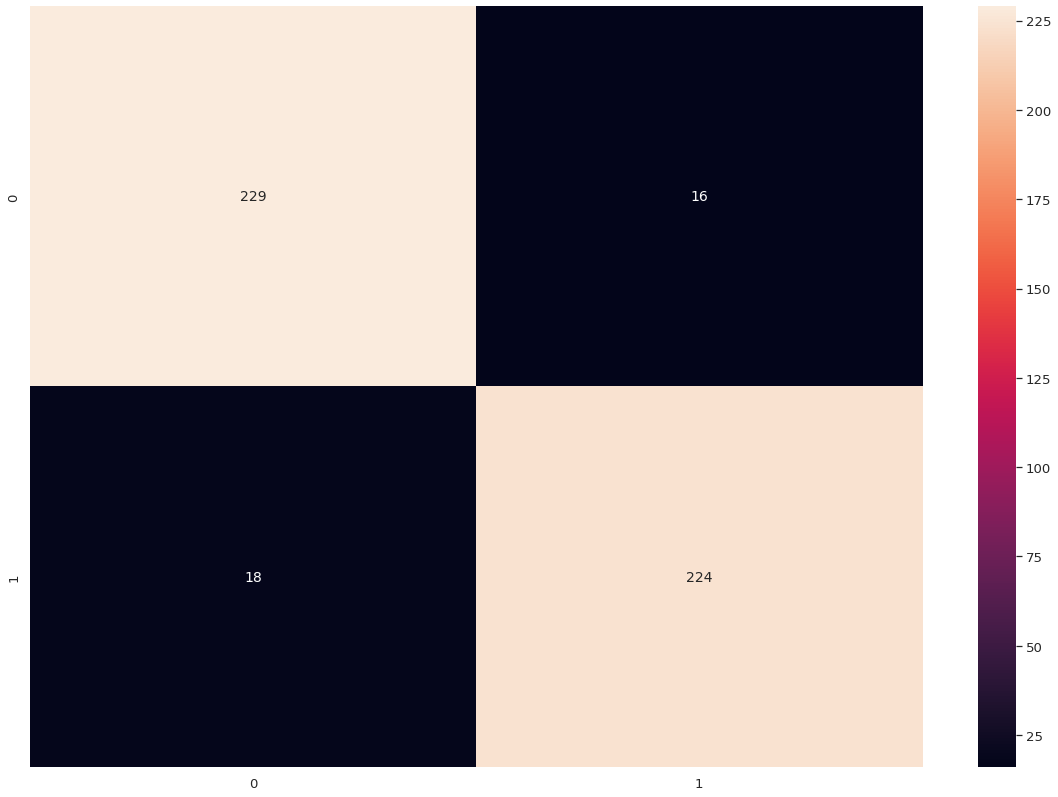

In [ ]:
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         neg     0.9271    0.9347    0.9309       245
         pos     0.9333    0.9256    0.9295       242

    accuracy                         0.9302       487
   macro avg     0.9302    0.9302    0.9302       487
weighted avg     0.9302    0.9302    0.9302       487



# Predict result from model1(CNN) and model2(CNN with Gensim)

**CNN model**

Prepare test data

In [ ]:
test_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments
2748,สแกนใบหน้าไม่ดีระบบควรปรับปรุง,1.0,0.0,11.9.1,2022-11-04 06:45:23,neg,สแกน ใบหน้า ไม่ ดี ระบบ ควร ปรับปรุง
2694,ใช้งานสะดวกสบาย,5.0,0.0,11.9.1,2022-11-06 17:08:55,pos,ใช้งาน สะดวกสบาย
1931,แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​,1.0,0.0,0.0.0,2022-10-22 13:27:32,neg,แย่มาก ​ ปรับปรุง ให้ ทัน ​ ค่าย อื่น ด้วย ค...
1575,ปิดปรับปรุงบ่อยมากคะแข้ไขั,3.0,0.0,0.0.0,2022-11-09 10:37:38,neg,ปิด ปรับปรุง บ่อย มาก คะ แข้ ไข ั
1934,โหลดไม่ได้,5.0,0.0,3.59.0,2022-10-22 10:12:28,neg,โหลด ไม่ ได้


In [ ]:
test_cleaned_words = test_df['clean_comments'].to_list()

In [ ]:
test_word_tokenizer = create_tokenizer(test_cleaned_words)

In [ ]:
test_encoded_doc = encoding_doc(test_word_tokenizer, test_cleaned_words)

In [ ]:
test_padded_doc = padding_doc(test_encoded_doc, max_length)
print("Shape of padded docs = ",test_padded_doc.shape)

print(test_cleaned_words[0])
print(test_encoded_doc[0])
print(test_padded_doc[0])

Shape of padded docs =  (609, 174)
สแกน ใบหน้า ไม่ ดี ระบบ ควร ปรับปรุง
[94, 110, 1, 4, 37, 148, 49]
[ 94 110   1   4  37 148  49   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
test_category = test_df['class'].to_list()

In [ ]:
test_unique_category = list(set(test_category))
test_unique_category

['neg', 'pos']

In [ ]:
test_output_tokenizer = create_tokenizer(test_unique_category)

In [ ]:
test_encoded_output = encoding_doc(test_output_tokenizer, test_category)
print(test_category[1:2])
print(test_encoded_output[1:2])

['pos']
[[2]]


In [ ]:
test_encoded_output = np.array(test_encoded_output).reshape(len(test_encoded_output), 1)
test_encoded_output.shape

(609, 1)

In [ ]:
test_output_one_hot = one_hot(test_encoded_output)
print(test_encoded_output[0])
print(test_output_one_hot[0])

[1]
[1. 0.]


In [ ]:
test_padded_doc

array([[  94,  110,    1, ...,    0,    0,    0],
       [  29,  135,    0, ...,    0,    0,    0],
       [  38,   50,   49, ...,    0,    0,    0],
       ...,
       [1137,   70,   67, ...,    0,    0,    0],
       [  11,   12,    7, ...,    0,    0,    0],
       [  23,  334,   53, ...,    0,    0,    0]], dtype=int32)

In [ ]:
predicted_classes_1 = np.argmax(predict_model.predict([test_padded_doc, test_padded_doc, test_padded_doc]), axis=-1)

20/20 [==============================] - 0s 17ms/step


In [ ]:
predicted_classes_1

array([0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,

In [ ]:
def mapClassLabel(n):
    mapClassList = []
    for classVal in n:
      if (classVal == 0):
        mapClassList.append("neg")
      elif (classVal == 1):
        mapClassList.append("pos")
    return mapClassList     

In [ ]:
cate_predicted_classes_1 = mapClassLabel(predicted_classes_1)
# predicted_classes_1

In [ ]:
test_df["predict_class"] = np.array(cate_predicted_classes_1)

test_df.head()

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
2748,สแกนใบหน้าไม่ดีระบบควรปรับปรุง,1.0,0.0,11.9.1,2022-11-04 06:45:23,neg,สแกน ใบหน้า ไม่ ดี ระบบ ควร ปรับปรุง,neg
2694,ใช้งานสะดวกสบาย,5.0,0.0,11.9.1,2022-11-06 17:08:55,pos,ใช้งาน สะดวกสบาย,pos
1931,แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​,1.0,0.0,0.0.0,2022-10-22 13:27:32,neg,แย่มาก ​ ปรับปรุง ให้ ทัน ​ ค่าย อื่น ด้วย ค...,neg
1575,ปิดปรับปรุงบ่อยมากคะแข้ไขั,3.0,0.0,0.0.0,2022-11-09 10:37:38,neg,ปิด ปรับปรุง บ่อย มาก คะ แข้ ไข ั,neg
1934,โหลดไม่ได้,5.0,0.0,3.59.0,2022-10-22 10:12:28,neg,โหลด ไม่ ได้,neg


In [ ]:
y_true_1 = np.argmax(test_output_one_hot,axis = 1)
print(test_output_one_hot[0])
print(y_true_1[0])

[1. 0.]
0


In [ ]:
cm_cnn = confusion_matrix(y_true_1, predicted_classes_1)
np.savetxt("confusion_matrix_CNN.csv", cm_cnn, delimiter=",")

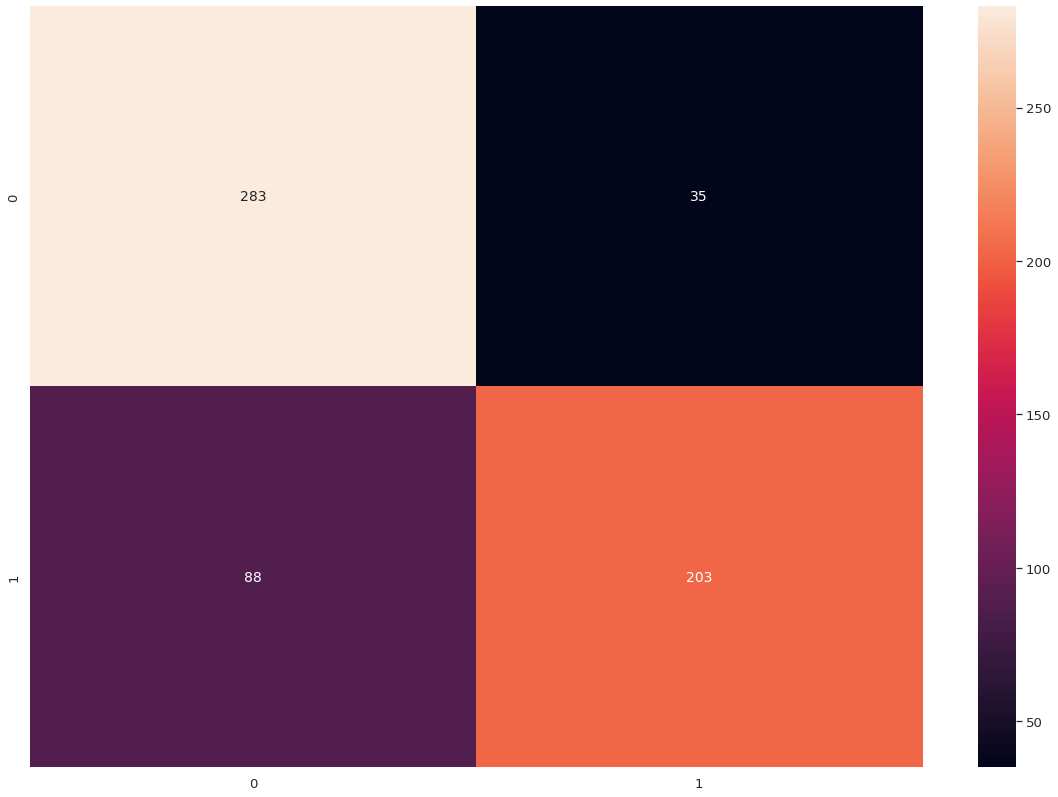

In [ ]:
test_df_cm_cnn = pd.DataFrame(cm_cnn, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(test_df_cm_cnn, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

Predict label compare with actual comment score.

In [ ]:
# test_df[(test_df['score'] >= 3) & (test_df['predict_class'] == "pos")]

query = test_df.query("score >= 3 and predict_class == 'pos'")

len(query)

212

In [ ]:
query

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
2694,ใช้งานสะดวกสบาย,5.0,0.0,11.9.1,2022-11-06 17:08:55,pos,ใช้งาน สะดวกสบาย,pos
2180,โหดๆ,5.0,0.0,3.59.0,2022-10-11 11:05:51,pos,โหด ๆ,pos
652,ดีมากเลยคับ,5.0,0.0,0.0.0,2022-10-31 12:46:36,pos,ดีมาก เลย คับ,pos
555,ดี,5.0,1.0,5.16.1,2022-11-02 17:11:15,pos,ดี,pos
2630,ใช้ดีมากๆค่ะ,5.0,0.0,0.0.0,2022-11-09 14:45:04,pos,ใช้ ดีมาก ๆ ค่ะ,pos
...,...,...,...,...,...,...,...,...
3367,ดี,5.0,0.0,11.9.1,2022-10-17 13:47:16,pos,ดี,pos
167,ดี,5.0,0.0,5.16.1,2022-11-09 09:10:40,pos,ดี,pos
702,ดีคับ,5.0,0.0,5.16.1,2022-10-30 13:44:12,pos,ดี คับ,pos
2867,สะดวกรวดเร็วในการไช้งาน,5.0,0.0,11.8.1,2022-10-31 00:49:35,pos,สะดวก รวดเร็ว ใน การ ไช้ งาน,pos


In [ ]:
# test_df[(test_df['score'] < 3) & (test_df['predict_class'] == "neg")]

query = test_df.query("score < 3 and predict_class == 'neg'")

len(query)

219

In [ ]:
query

,content,score,thumbsUpCount,reviewCreatedVersion,timestamp,class,clean_comments,predict_class
2748,สแกนใบหน้าไม่ดีระบบควรปรับปรุง,1.0,0.0,11.9.1,2022-11-04 06:45:23,neg,สแกน ใบหน้า ไม่ ดี ระบบ ควร ปรับปรุง,neg
1931,แย่มาก​ ปรับปรุงไห้ทัน​ค่ายอื่นด้วยค่ะ​,1.0,0.0,0.0.0,2022-10-22 13:27:32,neg,แย่มาก ​ ปรับปรุง ให้ ทัน ​ ค่าย อื่น ด้วย ค...,neg
2348,จะใช้งานไม่ได้ คับขันแย่ๆๆๆ ห่วยมากเลยทุกวันอะ...,1.0,0.0,0.0.0,2022-10-06 19:34:19,neg,จะ ใช้งาน ไม่ ได้ คับขัน แย่ ๆๆๆ ห่วย มาก ...,neg
126,ระบบเด่วนี้แย่มากๆมากบางทีก็อัปเดตแล้วก็เข้าใช...,1.0,0.0,5.16.3,2022-11-10 02:57:19,neg,ระบบ เด่ ว นี้ แย่มาก ๆ มาก บางที ก็ อัปเดต แล...,neg
379,เข้าแอฟโอนเงินไม่ได้เลย ขึ้นว่า (k plus หยุดแล...,1.0,0.0,0.0.0,2022-11-05 14:16:51,neg,เข้า แอปพลิเคชัน โอน เงิน ไม่ ได้ เลย ขึ้น ว...,neg
...,...,...,...,...,...,...,...,...
808,ช่วงนี้แอปเป็นอะไรคะ เราเข้าเฟสยุดีๆ แอปก้เด้ง...,2.0,1.0,5.16.1,2022-10-28 02:43:30,neg,ช่วงนี้ แอปพลิเคชัน เป็น อะไร คะ เรา เข้า เฟ...,neg
1714,อัพเดตใหม่แล้วไม่ต้องสแกนลายนิ้วมือไม่ต้องใส่ร...,1.0,20.0,3.60.0,2022-11-01 12:17:54,neg,อัปเดต ใหม่ แล้ว ไม่ต้อง สแกน ลายนิ้วมือ ไม่ต้...,neg
659,ลบแอพแล้วติดตั้งใหม่เข้าไม่ได้เลย,1.0,0.0,5.13.5,2022-10-31 10:15:42,neg,ลบ แอปพลิเคชัน แล้ว ติด ตั้งใหม่ เข้า ไม่ ได้ เลย,neg
3485,ทำไมสมัคแอปไม่ได้เลยคะทำหลายรอบมากก็ไม่ได้ ใคร...,1.0,0.0,11.9.1,2022-10-12 22:11:14,neg,ทำไม ส มัค แอปพลิเคชัน ไม่ ได้ เลย คะ ทำ หลาย ...,neg


Word cloud - positive comment

In [ ]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from wordcloud import WordCloud

In [ ]:
query_pos = test_df.query("predict_class == 'pos'")


text = " ".join(i for i in test_df.clean_comments)
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2
                      ).generate(text)

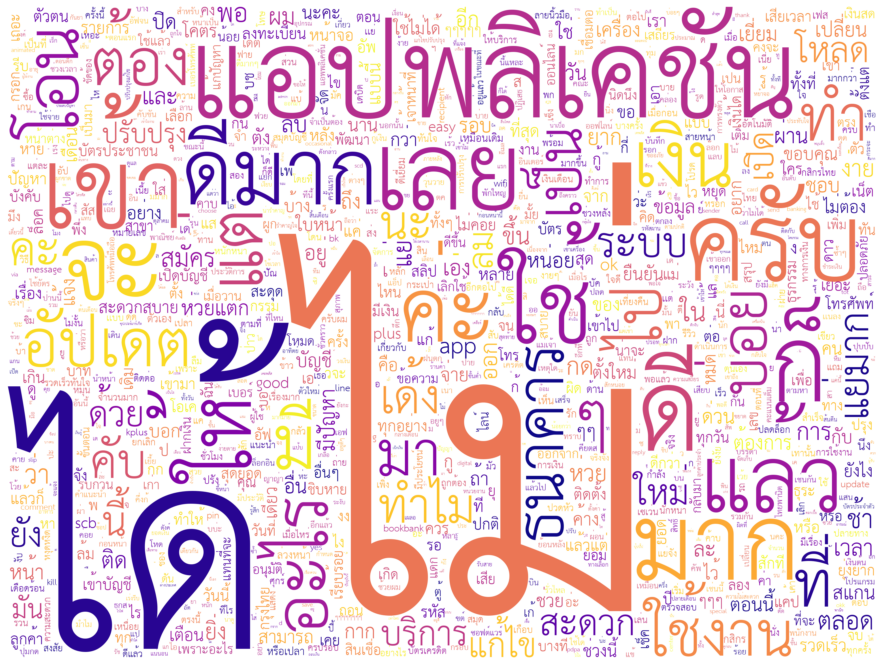

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()


Word cloud - negative comment

In [ ]:
query_neg = test_df.query("predict_class == 'neg'")


text = " ".join(i for i in test_df.clean_comments)
regexp = r"[ก-๙a-zA-Z']+"
wordcloud = WordCloud(
                      font_path="/content/THSarabunNew.ttf", 
                      relative_scaling = 0.3,
                      min_font_size=1,
                      background_color="white",
                      width=1024,
                      height=768,
                      max_words=2000, 
                      #mask=mask,
                      colormap='plasma', 
                      scale=3,
                      font_step=4,
                      contour_width=3, 
                      contour_color='steelblue', 
                      collocations=False,
                      regexp=regexp,
                      margin=2
                      ).generate(text)

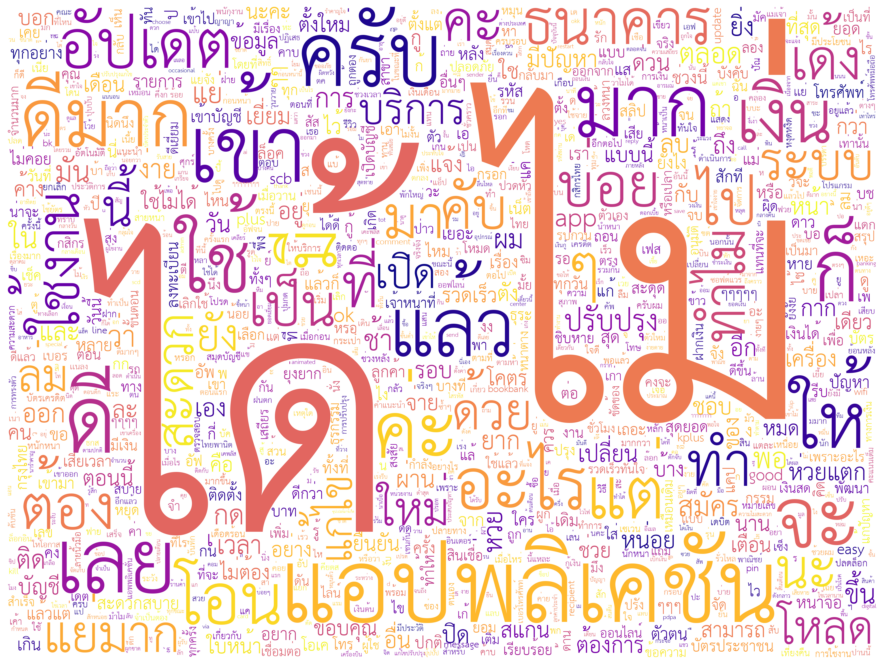

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

In [ ]:
test_df.to_csv("test_predict.csv", sep='\t', encoding='utf-8')